# **Hi!!**
This is my notbook for **Common Test-1. Multi-Class Classification**. I've first imported all the important libraries and then I've created a function which creates a list for all the npy files in train and val dataset. Following that I've created a custom dataset , Model class and have finally shown the ROC curve and AUC score after evaluating.

***Contents*** 
1. Importing Libraries
2. Creating list of .npy files
3. CustomDataset and DataLoaders
4. Model
5. Creating Modelfit
6. AND Finally Ploting the ROC_CURVE and AUC scores

In [8]:
# creating a dir "best_model" for saving the best model during traing 
!mkdir best_model

mkdir: cannot create directory ‘best_model’: File exists


>  Note: I will be running the notebook on kaggle most likely, For the sake of using better GPU 😊

# 1. Libraries

In [2]:
# importing all the libraries
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import  Dataset  , DataLoader
import torchvision.models as models
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import torchvision.transforms as transforms
from tqdm import tqdm

#path in which the best model will be saved 
best_classification_model = "/kaggle/working/best_model/model.pth"

In [3]:
import matplotlib.pyplot as plt

**2. Creating List of all the files in the Dataset**

In [4]:
def create_npy_list():
    Lens = ['no' , 'sphere' , 'vort'] #List of all lens classes
    train_paths = []
    val_paths = []
    lens = 0 # the index for the lens class
    for i in Lens:
        _ , _ , lists_train_npy = next(os.walk('/kaggle/input/dataset/dataset/train/'+ i))
        for l in range(len(lists_train_npy)):
            lists_train_npy[l] = i + "/" + lists_train_npy[l]
            train_paths.append((lists_train_npy[l] , lens))
        _ , _ , lists_val_npy = next(os.walk('/kaggle/input/dataset/dataset/val/'+ i))
        for l in range(len(lists_val_npy)):
            lists_val_npy[l] = i + "/" + lists_val_npy[l]
            val_paths.append((lists_val_npy[l] , lens))
        lens+=1
    return train_paths , val_paths

In [5]:
train_paths , val_paths = create_npy_list() 

In [6]:
# lets see the len of train_paths
print(len(train_paths))
# the first 10000 elements have "sub paths" of all the files from class 0/no the next 10000 are paths 
# for class 1/sphere and similarly rest are for class 2.vort .
print(train_paths[0])
print(train_paths[10000])

30000
('no/5955.npy', 0)
('sphere/5955.npy', 1)


# 3. Custom Dataset
Here I've created some transformation and have Defined the dataset class which returns lensimage as torch Tensor and its lens(0 , 1 , 2) respectively.

In [7]:
transform = transforms.Compose(
    
            [
                transforms.RandomVerticalFlip(0.5),
                transforms.RandomHorizontalFlip(p=0.5),
                
            ]
        )

In [8]:
class dataset(Dataset):
    def __init__(self , train, files ):
        self.files = files # files contains the list of sub paths of all .npy files
        self.train = train # a bool value to set 'dir' to train or val dataset's path
    def __len__(self):
        l = len(self.files)
        return l 
    
    def __getitem__(self , idx):
        if self.train:
            dir = "/kaggle/input/dataset/dataset/train/" # path of the trained dataset 
        else:
            dir = "/kaggle/input/dataset/dataset/val/" # path of validation dataset
            
        path , lens = self.files[idx] 
        PATH = dir + path
        image = np.load(PATH)
        image = torch.from_numpy(image)
        if self.train:
            image = transform(image)
        return image , lens                 #lens is either 0('no') , 1('sphere') , 2('vort')

In [9]:
train_data = dataset( train = True , files = train_paths)
val_data = dataset(train = False , files = val_paths)

In [10]:
# data loaders
train_loader = DataLoader(train_data ,  batch_size = 32 ,  shuffle = True )
valid_loader = DataLoader(val_data , batch_size = 32 , shuffle = True )

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# and its always a good idea to set the device to cuda if available 😊 ✌ 

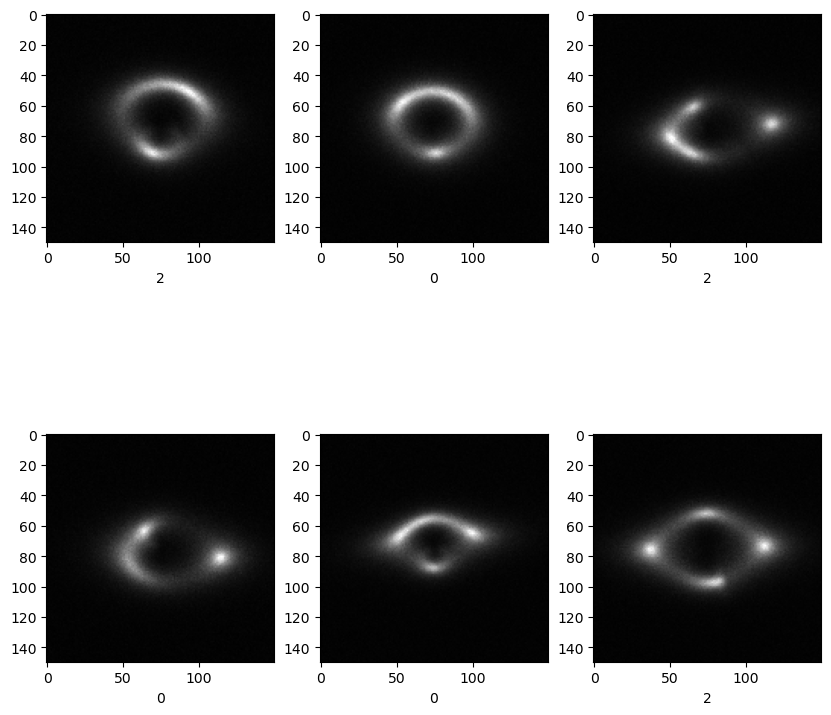

In [21]:
#ploting a few of the images

fig = plt.figure(figsize= (10,10))
for n , data in enumerate(train_loader):
    image = data[0]
    image = image[0][0]
    fig.add_subplot(2 , 3 , n +1)
    plt.imshow(image , cmap='gray')
    plt.xlabel(data[1][0].numpy())
    if n==5:
        break
plt.show()
# 0 -> no
# 1 -> sphere
# 2 vort

# 4. Model

I've used efficietnet_b5 with its pretrained Weights and have latter add a few of Linear layers. Adding custom linear layers on top of the pre-trained EfficientNet model is a good approach to fine-tune the model for a specific task. I've tried using many models like resnet , vgg but the best reuslts were given by efficientnets, I used efficientnet_b1 and efficientnet_b3, EfficientNet B5 may have required more training time but ultimately provided better accuracy compared to the B1 and B3 models.

In [36]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.model = models.efficientnet_b5(weights = True)
        self.model.features[0][0] = nn.Conv2d(1, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)      
        
        self.model.classifier[1] = nn.Sequential(
                                nn.Linear(2048, 512),
                                nn.ReLU(),
                                nn.Dropout(0.5),
                                nn.Linear(512, 256),
                                nn.ReLU(),
                                nn.Linear(256 , 3)
                                
                                
            
                                        )
    def forward(self, x):
        x = self.model(x)
        return x

In [37]:
model = Model().to(device) #setting the model to device in this case cuda.

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B5_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B5_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [38]:
# setting the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters() , 0.0001)

# CREATING Modelfit
(phew) Finally my most favourite part of using pytorch (●'◡'●) , training and evaluating the model. 
Here I've created three functions train , val and finally Modelfit.
here the 'img' which is a torchTensor, is converted to 'torch.FloatTensor' .
and will set to cuda if available, later coressponding losses and accuracy is calculated in both train_epoch and val_epoch, then function Modelfit prints the respective loss and accuracy and saves the best model.

In [39]:
def train_epoch(criterion , data_loader):
    Loss = 0
    accuracy = 0 
    model.train()
    tqdm(enumerate(data_loader) , total=len(data_loader))
    for n , (img , lens) in tqdm(enumerate(data_loader) , total=len(data_loader)) : 
        if device == 'cuda':
            img = img.type(torch.cuda.FloatTensor) #img is of shape (batch_size , 1 , 150 , 150)
        else:
            img = img.type(torch.FloatTensor)
        lens = lens.to(device)                   #lens --||--(batch_size)
    
    # forward 
        score = model(img)                         #score --||-- (lens.shape , 3) 
        loss = criterion(score , lens)
        Loss += loss
    
        _ , lens_idx = score.max(1) # lense_idx is set to the idex of the maximum value of the score
        correct_preds = (lens_idx == lens).float()
        acc = correct_preds.sum() / len(correct_preds)
        acc = (acc)*100
        accuracy += acc
        
    # backward
        optimizer.zero_grad() 
        loss.backward()
        optimizer.step()
        
    size = n + 1  
    accuracy = accuracy/size
    Loss = Loss/(size)
    return Loss.detach().cpu().numpy() , accuracy.detach().cpu().numpy()

In [40]:
def val_epoch(val_loader):
  model.eval()
  loss = 0 
  accuracy = 0
  with torch.no_grad():
    for i , ( img , y ) in tqdm(enumerate(val_loader) , total=(len(val_loader))):
      if device == 'cuda':
            img = img.type(torch.cuda.FloatTensor)
      else:
            img = img.type(torch.FloatTensor)
      y =y.to(device)
    
      score = model(img)
      l = criterion(score , y)
      loss+= l 
    
      _ , lens = score.max(1)
      correct_preds = (lens == y).float()
      acc = correct_preds.sum() / len(correct_preds)
      acc = (acc)*100
      accuracy += acc
    size = (i+1)
    loss = loss/size
    accuracy = accuracy/size
    return loss.detach().cpu().numpy() , accuracy.detach().cpu().numpy()
      

In [42]:
def Modelfit(train_loader , valid_loader):
    EPOCHS = 30
    criterion = nn.CrossEntropyLoss()
    best_loss = 10
    for epochs in range(EPOCHS):
        
       print("epochs {}/{} ".format(epochs + 1  , EPOCHS))
    
       train_loss , accuracy = train_epoch(criterion , train_loader)
        
       valid_loss , val_accuracy = val_epoch(valid_loader)
       
       print("train loss: {:.6f}".format(train_loss) ,  "valid_loss: {:.6f}".format(valid_loss) )
    
       print("train accuracy: {}  valid_accuracy: {}".format(accuracy , val_accuracy))
       
       if epochs == 1:
            best_loss = 10 
       if valid_loss < best_loss:
            best_loss = valid_loss
            torch.save(model.state_dict() , best_classification_model) #saving the best model 
       
Modelfit(train_loader , valid_loader)

epochs 1/30 


100%|██████████| 235/235 [00:29<00:00,  8.06it/s]


train loss: 1.098026 valid_loss: 1.095331
train accuracy: 34.63486099243164  valid_accuracy: 36.12145233154297
epochs 2/30 


100%|██████████| 235/235 [00:28<00:00,  8.24it/s]


train loss: 1.073367 valid_loss: 1.017623
train accuracy: 39.792110443115234  valid_accuracy: 47.21630859375
epochs 3/30 


100%|██████████| 235/235 [00:29<00:00,  8.09it/s]


train loss: 0.774886 valid_loss: 0.504119
train accuracy: 64.36234283447266  valid_accuracy: 79.233154296875
epochs 4/30 


100%|██████████| 235/235 [00:27<00:00,  8.40it/s]


train loss: 0.447928 valid_loss: 0.452236
train accuracy: 82.34941864013672  valid_accuracy: 84.7872314453125
epochs 5/30 


100%|██████████| 235/235 [00:27<00:00,  8.42it/s]


train loss: 0.318799 valid_loss: 0.271883
train accuracy: 87.90644836425781  valid_accuracy: 89.50797271728516
epochs 6/30 


100%|██████████| 235/235 [00:21<00:00, 10.76it/s]


train loss: 0.254928 valid_loss: 0.225912
train accuracy: 90.59501647949219  valid_accuracy: 91.77304077148438
epochs 7/30 


100%|██████████| 235/235 [00:28<00:00,  8.20it/s]


train loss: 0.220259 valid_loss: 0.211323
train accuracy: 92.06090545654297  valid_accuracy: 92.51329803466797
epochs 8/30 


100%|██████████| 235/235 [00:28<00:00,  8.39it/s]


train loss: 0.201188 valid_loss: 0.339452
train accuracy: 92.94709777832031  valid_accuracy: 87.85017395019531
epochs 9/30 


100%|██████████| 235/235 [00:21<00:00, 11.14it/s]


train loss: 0.173049 valid_loss: 0.185918
train accuracy: 93.91324615478516  valid_accuracy: 93.324462890625
epochs 10/30 


100%|██████████| 235/235 [00:27<00:00,  8.41it/s]


train loss: 0.161600 valid_loss: 0.187064
train accuracy: 94.23973846435547  valid_accuracy: 93.71453094482422
epochs 11/30 


100%|██████████| 235/235 [00:27<00:00,  8.52it/s]


train loss: 0.149432 valid_loss: 0.195654
train accuracy: 94.73947143554688  valid_accuracy: 93.03633880615234
epochs 12/30 


100%|██████████| 235/235 [00:21<00:00, 11.00it/s]


train loss: 0.138781 valid_loss: 0.166703
train accuracy: 95.1892318725586  valid_accuracy: 94.2021255493164
epochs 13/30 


100%|██████████| 235/235 [00:27<00:00,  8.47it/s]


train loss: 0.128628 valid_loss: 0.157246
train accuracy: 95.61567687988281  valid_accuracy: 94.76063537597656
epochs 14/30 


100%|██████████| 235/235 [00:27<00:00,  8.55it/s]


train loss: 0.121004 valid_loss: 0.151404
train accuracy: 95.73561096191406  valid_accuracy: 94.83155822753906
epochs 15/30 


100%|██████████| 235/235 [00:27<00:00,  8.57it/s]


train loss: 0.115629 valid_loss: 0.141689
train accuracy: 96.04544830322266  valid_accuracy: 95.28368377685547
epochs 16/30 


100%|██████████| 235/235 [00:28<00:00,  8.26it/s]


train loss: 0.107748 valid_loss: 0.152492
train accuracy: 96.31863403320312  valid_accuracy: 95.11967468261719
epochs 17/30 


100%|██████████| 235/235 [00:29<00:00,  8.07it/s]


train loss: 0.100515 valid_loss: 0.167186
train accuracy: 96.48188018798828  valid_accuracy: 94.1622314453125
epochs 18/30 


100%|██████████| 235/235 [00:26<00:00,  8.74it/s]


train loss: 0.096743 valid_loss: 0.157288
train accuracy: 96.65845489501953  valid_accuracy: 94.98670196533203
epochs 19/30 


100%|██████████| 235/235 [00:28<00:00,  8.17it/s]


train loss: 0.088503 valid_loss: 0.158340
train accuracy: 96.96495056152344  valid_accuracy: 95.07978057861328
epochs 20/30 


100%|██████████| 235/235 [00:26<00:00,  8.79it/s]


train loss: 0.086746 valid_loss: 0.143830
train accuracy: 97.06822967529297  valid_accuracy: 95.34574127197266
epochs 21/30 


100%|██████████| 235/235 [00:27<00:00,  8.42it/s]


train loss: 0.080523 valid_loss: 0.140959
train accuracy: 97.30144500732422  valid_accuracy: 95.70921325683594
epochs 22/30 


100%|██████████| 235/235 [00:19<00:00, 11.78it/s]


train loss: 0.080803 valid_loss: 0.141503
train accuracy: 97.27812194824219  valid_accuracy: 95.60282897949219
epochs 23/30 


100%|██████████| 235/235 [00:20<00:00, 11.65it/s]


train loss: 0.076485 valid_loss: 0.146427
train accuracy: 97.3747329711914  valid_accuracy: 95.05319213867188
epochs 24/30 


100%|██████████| 235/235 [00:20<00:00, 11.57it/s]


train loss: 0.076250 valid_loss: 0.142506
train accuracy: 97.39805603027344  valid_accuracy: 95.51861572265625
epochs 25/30 


100%|██████████| 235/235 [00:19<00:00, 11.84it/s]


train loss: 0.068248 valid_loss: 0.181286
train accuracy: 97.7278823852539  valid_accuracy: 95.1595687866211
epochs 26/30 


100%|██████████| 235/235 [00:20<00:00, 11.61it/s]


train loss: 0.064681 valid_loss: 0.149136
train accuracy: 97.8078384399414  valid_accuracy: 95.73580932617188
epochs 27/30 


100%|██████████| 235/235 [00:20<00:00, 11.56it/s]


train loss: 0.063392 valid_loss: 0.138135
train accuracy: 97.80117797851562  valid_accuracy: 95.66046142578125
epochs 28/30 


100%|██████████| 235/235 [00:21<00:00, 10.97it/s]


train loss: 0.060664 valid_loss: 0.149291
train accuracy: 97.90778350830078  valid_accuracy: 95.95744323730469
epochs 29/30 


100%|██████████| 235/235 [00:20<00:00, 11.49it/s]


train loss: 0.057604 valid_loss: 0.156767
train accuracy: 98.0477066040039  valid_accuracy: 94.60105895996094
epochs 30/30 


100%|██████████| 235/235 [00:20<00:00, 11.65it/s]


train loss: 0.054899 valid_loss: 0.132146
train accuracy: 98.11767578125  valid_accuracy: 95.93084716796875


* Loading The Best model

In [30]:
model.load_state_dict(torch.load('/kaggle/working/best_model/model.pth'))

<All keys matched successfully>

# Ploting the ROC Curve and AUC score

* Evaluating the best_model on the Validation dataset

In [43]:
true_y = []
pred_y = []
y_pred_prob_list = []
for n , (img , y) in enumerate(valid_loader):
    img = img.to(device)
    img = img.type(torch.cuda.FloatTensor)
    score = model(img)
    y_pred_prob_list.append(torch.softmax(score, dim = 1).detach().cpu().numpy())
    _ , lens = torch.max(score , dim=1)
    pred_y.append(lens.detach().cpu().numpy())
    true_y.append(y.detach().cpu().numpy())

In [44]:
true = []
for i in true_y:
    for j in i:
        true.append(j)
prob = []
for i in y_pred_prob_list:
    for j in (i) :     
         prob.append(j)
pred = []
for i in pred_y:
    for j in i:
        pred.append(j)

* Ploting the confusion Metrics

<AxesSubplot:>

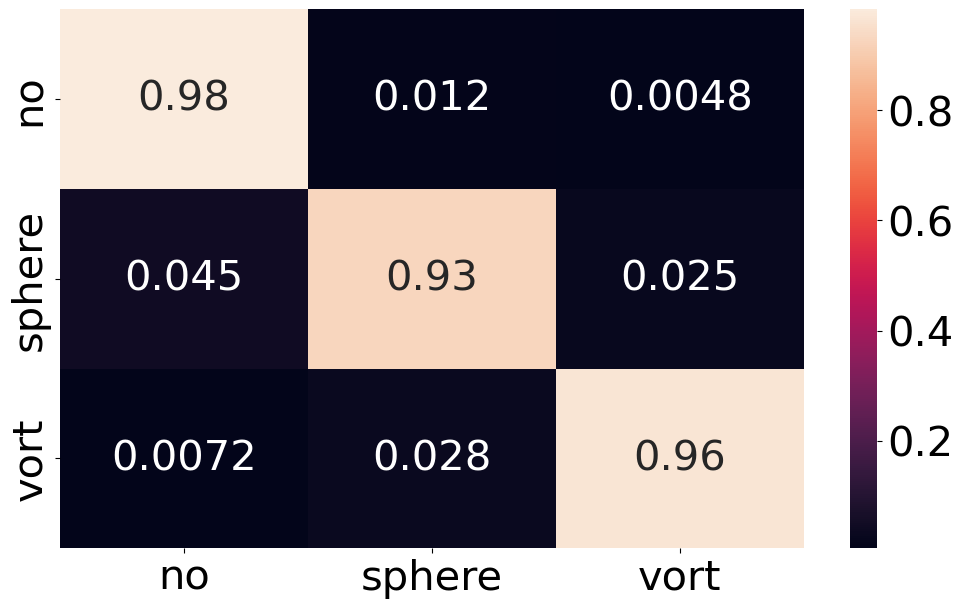

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
classes = ('no', 'sphere', 'vort')

cf_matrix = confusion_matrix(true, pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)

In [46]:
fpr = { }
tpr = { }
roc_auc = { }
thresh ={ }

n_class = 3

for i in range(n_class):    
     fpr[i], tpr[i], thresh[i] = metrics.roc_curve(np.array(true), np.array(prob)[:,i], pos_label=i)
     roc_auc[i] = metrics.auc(fpr[i], tpr[i])

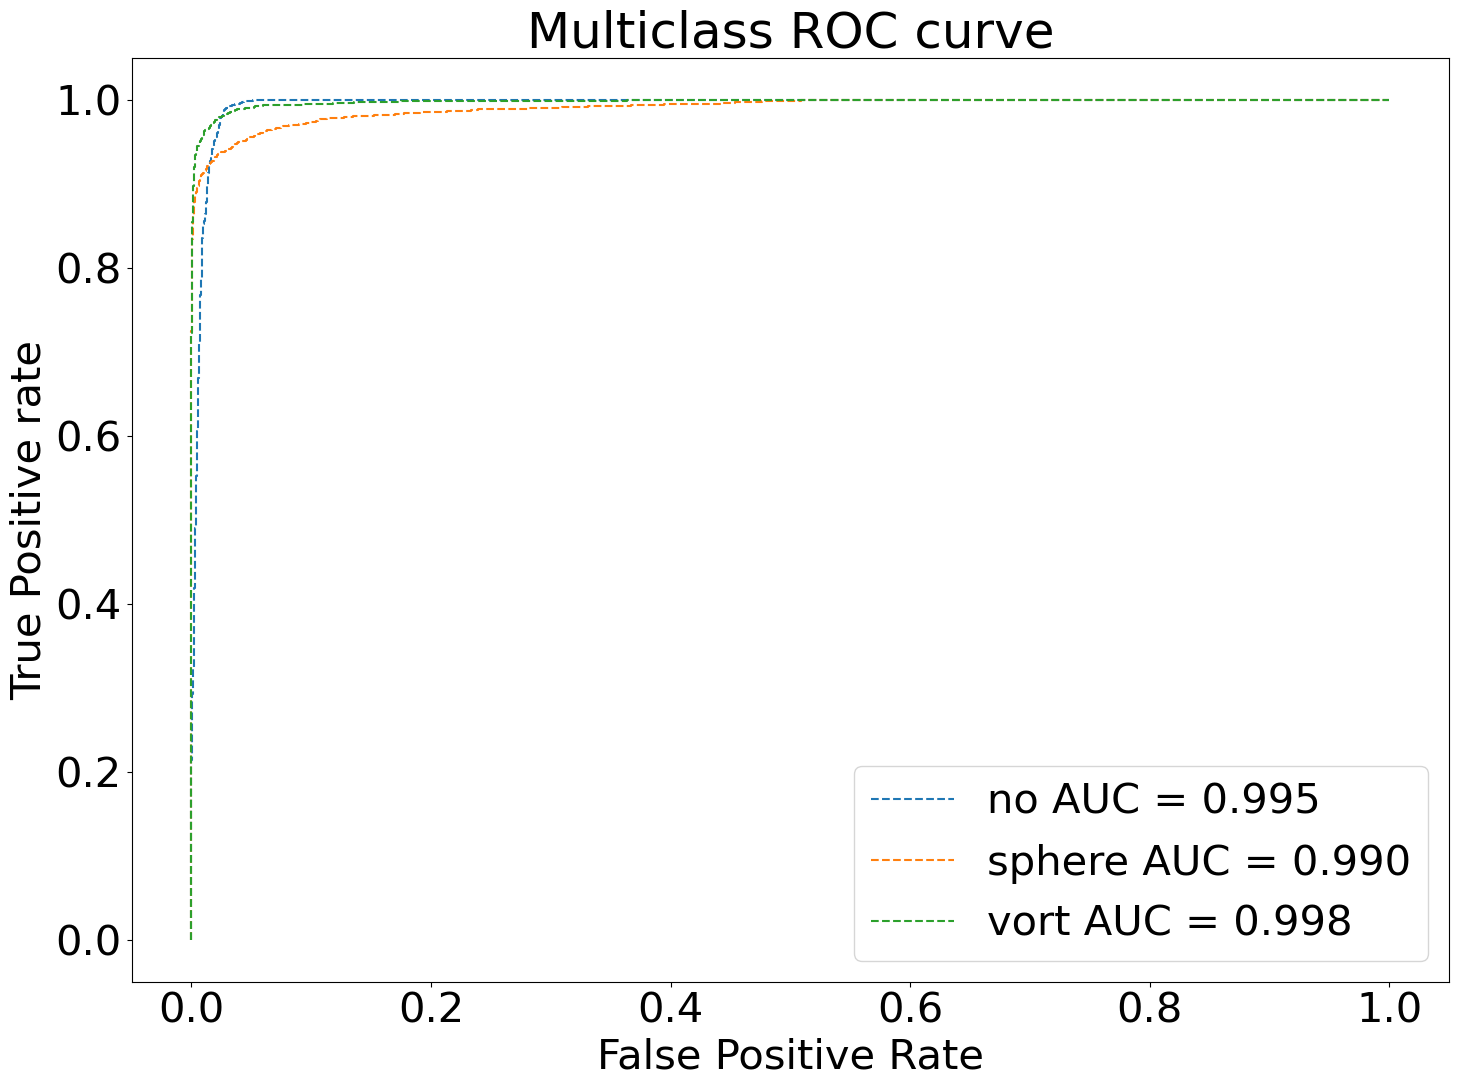

In [47]:
classes = ['no' , 'sphere' , 'vort']
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '30'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{classes[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')

The model gave the best accuracy of 95.95% on the validation dataset.
The ROC_Curve is plotted and the AUC scores are all > 0.99.Training the model with more epochs can give accuracy of 99% on trainig dataset but the vaidation accuracy will wonder around 94.


*Reference*

[Deep Learning the Morphology of Dark Matter Substructure](https://arxiv.org/abs/1909.07346)

And thus the end of my sloution to Common Test for DeepLens

Thnx😊✌